# **1) Install requirements**

In [ ]:
!apt-get install -y openjdk-11-jdk-headless
!pip install pyspark
!pip install graphframes

from pyspark.sql import SparkSession
from pyspark.sql.functions import desc
spark = (SparkSession.builder
         .appName("TP5 GraphFrames")
         .config("spark.jars.packages","graphframes:graphframes:0.8.3-spark3.5-s_2.12")
         .getOrCreate())

print("Spark started!")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk-headless is already the newest version (11.0.28+6-1ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Spark started!


# **2) Load dataframes**

In [ ]:
stations = spark.read.csv("/content/drive/MyDrive/station_data.csv", header=True, inferSchema=True)
trips = spark.read.csv("/content/drive/MyDrive/trip_data.csv", header=True, inferSchema=True)

stations.show(5)
trips.show(5)

+----------+--------------------+---------+-----------+---------+--------+------------+
|station_id|                name|      lat|       long|dockcount|landmark|installation|
+----------+--------------------+---------+-----------+---------+--------+------------+
|         2|San Jose Diridon ...|37.329732|-121.901782|       27|San Jose|    8/6/2013|
|         3|San Jose Civic Ce...|37.330698|-121.888979|       15|San Jose|    8/5/2013|
|         4|Santa Clara at Al...|37.333988|-121.894902|       11|San Jose|    8/6/2013|
|         5|    Adobe on Almaden|37.331415|  -121.8932|       19|San Jose|    8/5/2013|
|         6|    San Pedro Square|37.336721|-121.894074|       15|San Jose|    8/7/2013|
+----------+--------------------+---------+-----------+---------+--------+------------+
only showing top 5 rows

+-------+--------+---------------+--------------------+--------------+---------------+--------------------+------------+------+---------------+--------+
|Trip ID|Duration|     Start D

# **3) Rename name → id for vertices**

In [ ]:
vertices = stations.withColumnRenamed("name", "id")
vertices.show(5)

+----------+--------------------+---------+-----------+---------+--------+------------+
|station_id|                  id|      lat|       long|dockcount|landmark|installation|
+----------+--------------------+---------+-----------+---------+--------+------------+
|         2|San Jose Diridon ...|37.329732|-121.901782|       27|San Jose|    8/6/2013|
|         3|San Jose Civic Ce...|37.330698|-121.888979|       15|San Jose|    8/5/2013|
|         4|Santa Clara at Al...|37.333988|-121.894902|       11|San Jose|    8/6/2013|
|         5|    Adobe on Almaden|37.331415|  -121.8932|       19|San Jose|    8/5/2013|
|         6|    San Pedro Square|37.336721|-121.894074|       15|San Jose|    8/7/2013|
+----------+--------------------+---------+-----------+---------+--------+------------+
only showing top 5 rows



# **4) Rename trip columns: Start Station → src, End Station → dst**

In [ ]:
edges = trips.withColumnRenamed("Start Station", "src") \
             .withColumnRenamed("End Station", "dst")
edges.show(5)

+-------+--------+---------------+--------------------+--------------+---------------+--------------------+------------+------+---------------+--------+
|Trip ID|Duration|     Start Date|                 src|Start Terminal|       End Date|                 dst|End Terminal|Bike #|Subscriber Type|Zip Code|
+-------+--------+---------------+--------------------+--------------+---------------+--------------------+------------+------+---------------+--------+
| 913460|     765|8/31/2015 23:26|Harry Bridges Pla...|            50|8/31/2015 23:39|San Francisco Cal...|          70|   288|     Subscriber|    2139|
| 913459|    1036|8/31/2015 23:11|San Antonio Shopp...|            31|8/31/2015 23:28|Mountain View Cit...|          27|    35|     Subscriber|   95032|
| 913455|     307|8/31/2015 23:13|      Post at Kearny|            47|8/31/2015 23:18|   2nd at South Park|          64|   468|     Subscriber|   94107|
| 913454|     409|8/31/2015 23:10|  San Jose City Hall|            10|8/31/2015 23

# **5) Create the GraphFrame**

In [ ]:
from graphframes import GraphFrame

g = GraphFrame(vertices, edges)
g

GraphFrame(v:[id: string, station_id: int ... 5 more fields], e:[src: string, dst: string ... 9 more fields])

# **6) Trips starting OR ending at "Townsend at 7th" sorted descending**

In [ ]:
edges.where("src = 'Townsend at 7th' OR dst = 'Townsend at 7th'").groupBy("src", "dst").count().orderBy(desc("count")).show()

+--------------------+--------------------+-----+
|                 src|                 dst|count|
+--------------------+--------------------+-----+
|San Francisco Cal...|     Townsend at 7th|    4|
|       5th at Howard|     Townsend at 7th|    1|
|     Townsend at 7th|     Spear at Folsom|    1|
|     Townsend at 7th|Harry Bridges Pla...|    1|
|     Spear at Folsom|     Townsend at 7th|    1|
|       Howard at 2nd|     Townsend at 7th|    1|
+--------------------+--------------------+-----+



# **7) Stations that were NEVER a destination of a trip starting from "Spear at Folsom"**

In [ ]:
start_station = "Spear at Folsom"

destinations = edges.filter(edges.src == start_station).select("dst").distinct()
never_dest = vertices.join(destinations, vertices.id == destinations.dst, "left_anti")

never_dest.show()


+----------+--------------------+---------+-----------+---------+------------+------------+
|station_id|                  id|      lat|       long|dockcount|    landmark|installation|
+----------+--------------------+---------+-----------+---------+------------+------------+
|         2|San Jose Diridon ...|37.329732|-121.901782|       27|    San Jose|    8/6/2013|
|         3|San Jose Civic Ce...|37.330698|-121.888979|       15|    San Jose|    8/5/2013|
|         4|Santa Clara at Al...|37.333988|-121.894902|       11|    San Jose|    8/6/2013|
|         5|    Adobe on Almaden|37.331415|  -121.8932|       19|    San Jose|    8/5/2013|
|         6|    San Pedro Square|37.336721|-121.894074|       15|    San Jose|    8/7/2013|
|         7|Paseo de San Antonio|37.333798|-121.886943|       15|    San Jose|    8/7/2013|
|         8| San Salvador at 1st|37.330165|-121.885831|       15|    San Jose|    8/5/2013|
|         9|           Japantown|37.348742|-121.894715|       15|    San Jose|  

# **8) Station with the maximum number of incoming trips**

In [ ]:
incoming = edges.groupBy("dst").count().orderBy("count", ascending=False)
incoming.show(1)

+--------------------+-----+
|                 dst|count|
+--------------------+-----+
|San Francisco Cal...|    9|
+--------------------+-----+
only showing top 1 row



# **9) Trip with the maximum duration**

In [ ]:
trips.orderBy("Duration", ascending=False).show(1)

+-------+--------+---------------+--------------------+--------------+---------------+--------------------+------------+------+---------------+--------+
|Trip ID|Duration|     Start Date|       Start Station|Start Terminal|       End Date|         End Station|End Terminal|Bike #|Subscriber Type|Zip Code|
+-------+--------+---------------+--------------------+--------------+---------------+--------------------+------------+------+---------------+--------+
| 913386|    1808|8/31/2015 20:23|Embarcadero at Br...|            54|8/31/2015 20:53|Harry Bridges Pla...|          50|   524|     Subscriber|   94105|
+-------+--------+---------------+--------------------+--------------+---------------+--------------------+------------+------+---------------+--------+
only showing top 1 row



# **10) Subgraph containing trips that start OR end at "Townsend at 7th"**

In [ ]:
sub_edges = edges.filter(
    (edges.src == "Townsend at 7th") | (edges.dst == "Townsend at 7th")
)

stations_in_sub = sub_edges.select("src").union(sub_edges.select("dst")).distinct()

sub_vertices = vertices.join(stations_in_sub, vertices.id == stations_in_sub.src, "inner")

subgraph = GraphFrame(sub_vertices, sub_edges)
subgraph

GraphFrame(v:[id: string, station_id: int ... 6 more fields], e:[src: string, dst: string ... 9 more fields])

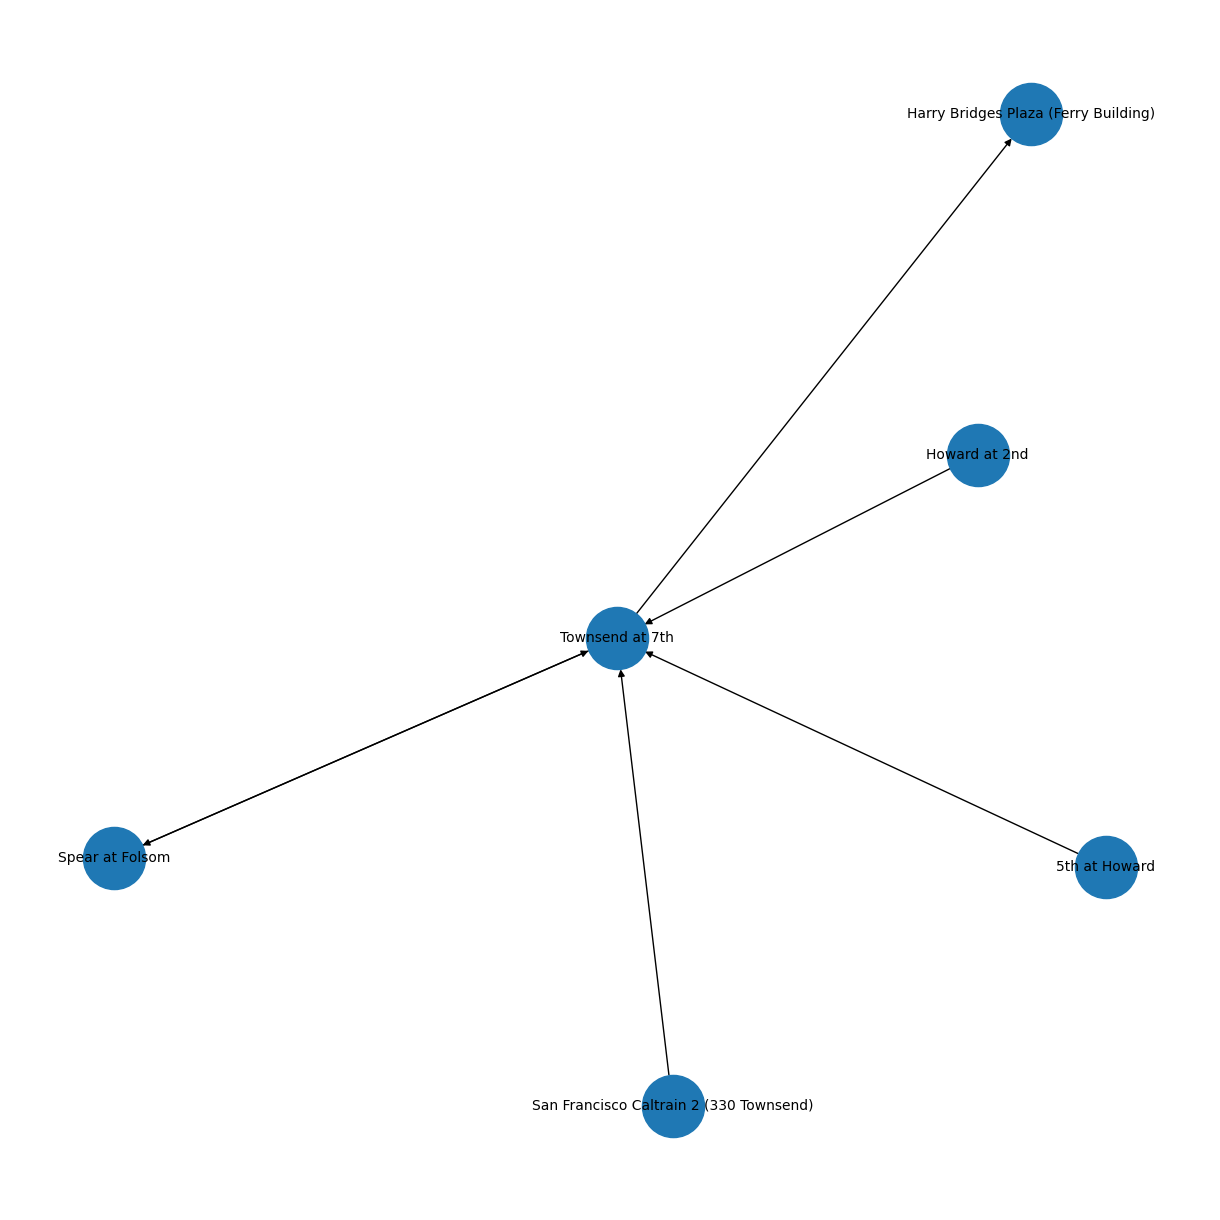

In [ ]:
sub_edges = edges.filter(
    (edges.src == "Townsend at 7th") | (edges.dst == "Townsend at 7th")
)

stations_in_sub = sub_edges.select("src").union(sub_edges.select("dst")).distinct()

sub_vertices = vertices.join(
    stations_in_sub,
    vertices.id == stations_in_sub.src,
    "inner"
)

subgraph = GraphFrame(sub_vertices, sub_edges)

# -------------------------
# VISUALIZE SUBGRAPH WITH NETWORKX
# -------------------------
v_pdf = sub_vertices.toPandas()
e_pdf = sub_edges.toPandas()

import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add nodes
for _, row in v_pdf.iterrows():
    G.add_node(row["id"])

# Add edges
for _, row in e_pdf.iterrows():
    G.add_edge(row["src"], row["dst"])

plt.figure(figsize=(12, 12))
nx.draw(G, with_labels=True, node_size=2000, font_size=10, arrows=True)
plt.show()

# **11) Return all “triangle” motifs (A → B → C → A)**

In [ ]:
triangles = g.find("(a)-[ab]->(b); (b)-[bc]->(c); (c)-[ca]->(a)")
triangles.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                   a|                  ab|                   b|                  bc|                   c|                  ca|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|{60, Embarcadero ...|{913450, 255, 8/3...|{74, Steuart at M...|{913315, 518, 8/3...|{61, 2nd at Towns...|{913383, 1435, 8/...|
|{60, Embarcadero ...|{913443, 691, 8/3...|{77, Market at Sa...|{913403, 497, 8/3...|{61, 2nd at Towns...|{913383, 1435, 8/...|
|{69, San Francisc...|{913434, 283, 8/3...|{65, Townsend at ...|{913371, 663, 8/3...|{49, Spear at Fol...|{913432, 703, 8/3...|
|{49, Spear at Fol...|{913432, 703, 8/3...|{69, San Francisc...|{913308, 185, 8/3...|{61, 2nd at Towns...|{913297, 501, 8/3...|
|{49, Spear at Fol...|{913432, 703, 8/3...|{69, San Francisc...|{913316, 300, 8/3...|{65, Townsend at ..

# **12) All paths of length 3 starting from "Townsend at 7th"**

In [ ]:
paths = g.find("(a)-[ab]->(b); (b)-[bc]->(c)") \
         .filter("a.id = 'Townsend at 7th'")

paths.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                   a|                  ab|                   b|                  bc|                   c|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|{65, Townsend at ...|{913382, 645, 8/3...|{50, Harry Bridge...|{913349, 559, 8/3...|{61, 2nd at Towns...|
|{65, Townsend at ...|{913382, 645, 8/3...|{50, Harry Bridge...|{913415, 274, 8/3...|{54, Embarcadero ...|
|{65, Townsend at ...|{913382, 645, 8/3...|{50, Harry Bridge...|{913460, 765, 8/3...|{70, San Francisc...|
|{65, Townsend at ...|{913371, 663, 8/3...|{49, Spear at Fol...|{913290, 273, 8/3...|{61, 2nd at Towns...|
|{65, Townsend at ...|{913371, 663, 8/3...|{49, Spear at Fol...|{913344, 326, 8/3...|{42, Davis at Jac...|
|{65, Townsend at ...|{913371, 663, 8/3...|{49, Spear at Fol...|{913379, 803, 8/3...|{65, Townsend at ...|
|{65, Townsend at ...|{913371, 663, 8